In [1]:
include("./../runSim.jl")
pwd()

"/home/javier/Projects/DiffSolver/tools"

In [2]:
# CUDA.devices()
device!(3)  

┌ Warning: Support for GPU memory limits (JULIA_CUDA_MEMORY_LIMIT) has been removed.
└ @ CUDA /home/javier/.julia/packages/CUDA/sCev8/src/initialization.jl:75


CuDevice(3): NVIDIA A100-SXM4-80GB

In [3]:
α₁, _ = genInitialCond(512, 5, true)
gMx, gMy = gen_op(size(α₁,1), true)        # This generates the discrete laplacian as in CR's tutorial
r1 = 1.0/400.0
Dd = 1.0
if true
    gMyA = CuArray(Float32.(zeros(size(gMx))))
    gAMx = CuArray(Float32.(zeros(size(gMx))))
    gDA = CuArray(Float32.(zeros(size(gMx))))
else
    gMyA = zeros(size(gMx))
    gAMx = zeros(size(gMx))
    gDA = zeros(size(gMx))
end
u0 = α₁

512×512 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0

In [4]:
function genTuples(idx, in_cond, dist, use_gpu; s=100, radius=5, tmax=3000.0,
            dir = "newdata")
  α₁ = in_cond
  u0 = α₁
  if use_gpu
      prob = ODEProblem{false}(f,u0,(0.0,tmax),α₁)
#       @time sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
    sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
  else
      prob = ODEProblem{false}(fCPU,u0,(0.0,tmax),α₁)
#       @time sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)
    sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)
  end
  out = Array(sol[end])/maximum(sol[end])    #radius^2

#   path = PATH * dir * "/test2"   # temp: remove test2
#   isdir(path) || mkpath(path)
#   writedlm(path * "/Cell_$idx.dat", reshape(Array(α₁),:))
#   writedlm(path * "/Field_$idx.dat", reshape(out,:))
  # writedlm(path * "/Dist_$idx.dat", dist)
  Array(α₁), out
end

function runFunction(start, stop, dir; ns=1, gridSize=100, radius = 5)
  for i in start:stop
    @info i
    in_cond, dist = genInitialCond(gridSize, r, use_gpu; ns=ns)
    init_cond, final_state = genTuples(i, in_cond, dist, use_gpu; dir=dir)
    # f1 = heatmap(init_cond)
    # f2 = heatmap(final_state)
    # fig = plot(f1,f2, layout = @layout grid(2,1))
    # display(fig)
    CUDA.reclaim()
    if log
        flush(io)
    end
  end
end

runFunction (generic function with 1 method)

In [5]:
function genInitialCond(s, radius, use_gpu; ns=1, pos=[50 50])
  ar = [[i,j] for i in 1:s, j in 1:s]
  dist = zeros(ns)
  init_cond = zeros(s,s)
  for ns0 in 1:ns
    if size(pos,1) != 0
        source = [pos[ns0,1], pos[ns0,2]]
    else
        source = [rand(radius:s-radius), rand(radius:s-radius)]
    end
    dist[ns0] = min_dist_to_border(source, s)
    init_cond = init_cond .+ [in_source(ar[i,j][1], source[1], ar[i,j][2], source[2], radius) for i in 1:s, j in 1:s] .* rand(0.01:0.0000001:1.0)
  end

  if use_gpu
      CuArray{Float32,2}(init_cond/maximum(init_cond)), dist
  else
      init_cond/maximum(init_cond), dist
  end
#   CuArray{Float32,2}(min.(init_cond,1.0)), dist
end

genInitialCond (generic function with 1 method)

In [5]:
256-94

162

In [6]:
in_cond, dist = genInitialCond(512, 20, true; ns=9, pos=[256 256; 306 306; 212 306; 212 212; 312 212; 256 326; 256 196; 326 256; 196 256])
a,b = genTuples(1, in_cond, dist, true)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[7.940307f-10 1.6229151f-9 … 1.2622097f-9 6.425837f-10; 1.6289342f-9 3.233525f-9 … 2.4945686f-9 1.2700659f-9; … ; 1.5881613f-9 3.133034f-9 … 4.819497f-9 2.397868f-9; 7.7976264f-10 1.559006f-9 … 2.390992f-9 1.2612055f-9])

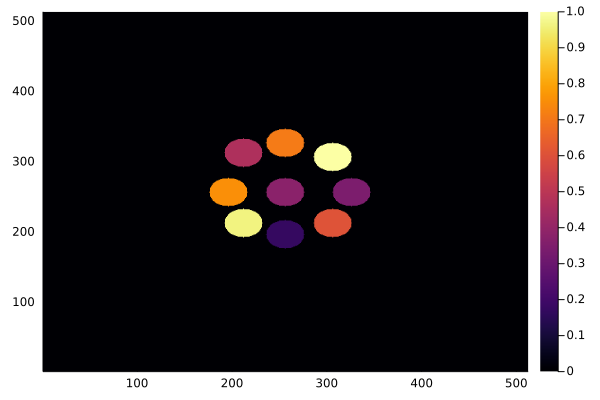

In [7]:
heatmap(Array(a))

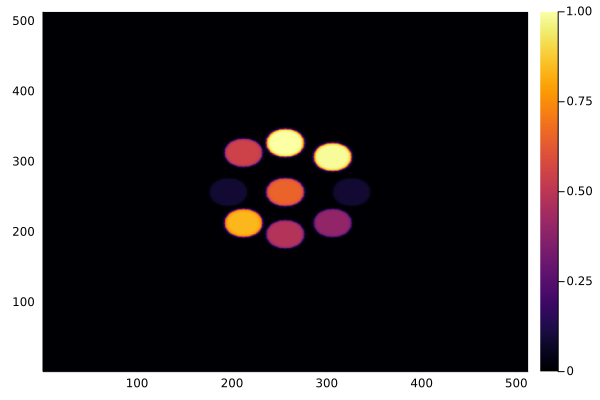

In [69]:
heatmap(Array(b))

In [20]:
sqrt(2)*512

724.0773439350247

In [70]:
α₁ = in_cond
u0 = α₁
#   if use_gpu
# prob = ODEProblem{false}(f,u0,(0.0,tmax),α₁)
# sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
#   else
prob = ODEProblem{false}(f,u0,(0.0,2000.0),α₁)
sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)

out = Array(sol[end])#/maximum(sol[end])    #radius^2

512×512 Matrix{Float32}:
  1.18365f-9    2.08418f-10  -1.16601f-9   …   1.9468f-10    3.94031f-10
  2.08418f-10  -5.00427f-11  -2.29336f-10      1.08169f-10  -9.99575f-11
 -1.16601f-9   -2.29336f-10   1.10487f-9      -9.81336f-11  -3.36506f-10
 -4.75684f-10   2.87273f-11   4.33861f-10     -1.7829f-10    2.15544f-10
  9.89672f-10   1.74984f-10  -9.44517f-10     -9.19634f-11   2.28209f-10
  7.01757f-10   1.92226f-11  -5.48398f-10  …   1.28974f-10  -3.75742f-10
 -5.5294f-10    1.50032f-11   6.71163f-10      2.87169f-10  -1.39918f-10
 -6.45498f-10   5.6027f-11    4.99745f-10      8.96101f-11   5.51981f-10
 -1.45875f-12  -2.12823f-10  -3.38703f-10     -2.97745f-10   1.96432f-10
  1.76041f-10  -3.17573f-10  -2.90819f-10     -3.50217f-10  -5.67168f-10
  3.12074f-10   1.37606f-10   2.41295f-11  …   1.2066f-11   -4.13403f-10
  4.49548f-10   5.24016f-10   2.21411f-11      3.6349f-10    1.85011f-10
 -1.67395f-10   3.09307f-10   2.51416f-10      3.6025f-10    5.32738f-10
  ⋮                       

In [71]:
heatmap(Array(out))
maximum(out)

1.0078671f0

In [64]:
sqrt(r1/Dd) * pi * 20 / maximum(out)

7.208991456291373

In [46]:
using Statistics
mean(Array(out)/maximum(Array(out))-Array(b))

-2.3730436f-6

 # Compute source distances


In [6]:
pos = [(rand(1:512), rand(1:512)) for i in 1:20]
# pos = [(rand()*512, rand()*512) for i in 1:20]

20-element Vector{Tuple{Float64, Float64}}:
 (171.14449485394624, 33.170940188196596)
 (251.1383049515157, 464.86257542937386)
 (264.00007624409085, 213.78271713603777)
 (186.1430653130127, 307.92377392192253)
 (377.8547005038357, 185.47052482701372)
 (475.74976683192375, 297.8274665631774)
 (460.9276788444959, 13.785777460867621)
 (500.1737909964605, 381.07823741154874)
 (173.81920225935613, 149.11328849285417)
 (311.25388092172074, 0.06512276334848366)
 (392.65414931548725, 436.5279139619178)
 (132.86431295910484, 345.2138389369275)
 (502.4003696886684, 492.8851563153805)
 (360.224820060801, 204.11399554306547)
 (276.3075168880808, 136.19230528409372)
 (315.3170941141814, 441.1081451019045)
 (200.3550557428735, 431.36331321053785)
 (52.49703494348506, 222.94885257903553)
 (100.70955091791859, 467.34705796667635)
 (158.3651678494649, 380.624263956137)

In [7]:
include("./computeSrcsDistance.jl")

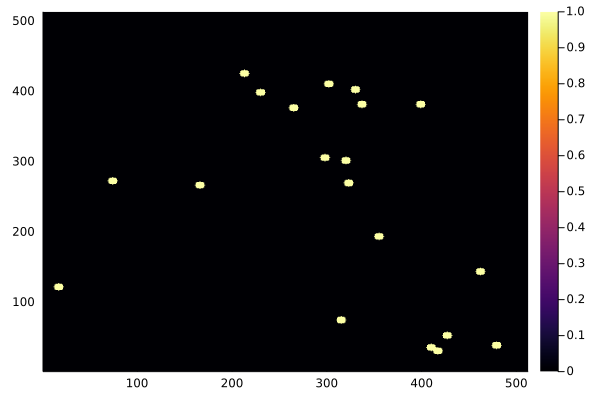

In [91]:
# a, dist = genInitialCond(512, 20, true; ns=2, pos=[256 256; 306 306; 212 306; 212 212; 312 212; 256 326; 256 196; 326 256; 196 256])
a, dist = genInitialCond(512, 5, true; ns=20, pos=[])
# a, dist = genInitialCond(512, 1, true; ns=1000, pos=[])
heatmap(sign.(Array(a)))


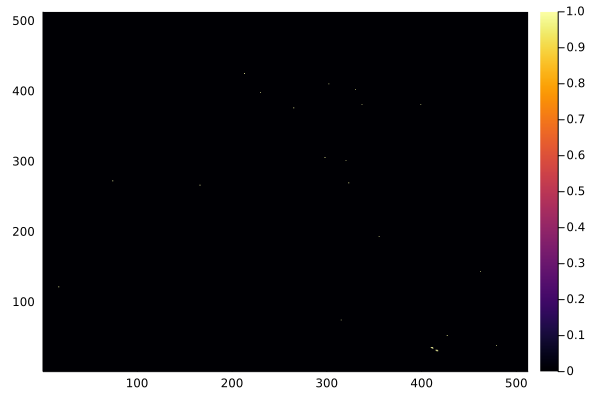

In [104]:
arr = cropSource(sign.(Array(a)));
# arr = sign.(Array(a));
pos = findall(x-> x==1,arr)
heatmap(arr)

In [100]:
dis = [[sqrt((pos[i][1]-pos[j][1])^2 + (pos[i][2]-pos[j][2])^2) for i in 1:size(pos,1)] for j in 1:size(pos,1)];

# plot(dis[dis .> 2], st=:histogram, normalized=true, label=:none)

In [33]:
@show mean(dis)
@show median(dis)
# @show mode(dis)

mean(dis) = 263.29111345891835
median(dis) = 252.98977383351394


252.98977383351394

In [34]:
512*0.33 * sqrt(2)

238.94552349855817

# Analysis of Pairwise source distance

In [17]:
d = Dict()
for i in 1:size(DS,1)
    d[DS[i]] = reshape(readdlm(PATH * DS[i] * "/SrcsDistStat.dat"),:);
end

In [18]:
using Statistics, StatsBase

In [25]:
mvals = [mean(d[key]) for key in DS]
stdvals = [std(d[key]) for key in DS];
medvals = [median(d[key]) for key in DS];
modvals = [mode(d[key]) for key in DS];

In [ ]:
p = []
for i in 1:4000
    pos = [(rand(1:512), rand(1:512)) for i in 1:20]
    dis = [[sqrt((pos[i][1]-pos[j][1])^2 + (pos[i][2]-pos[j][2])^2) for i in 1:size(pos,1)] for j in 1:size(pos,1)];
    append!(p, [sort(dis[i][dis[i] .> 0.1])[1] for i in 1:size(dis,1)])
end

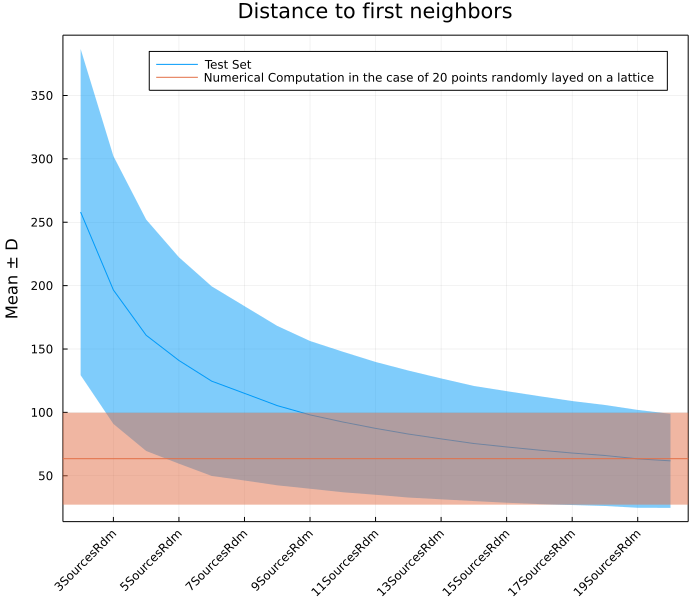

In [48]:
# plot(mvals, ribbon=stdvals)
plot(DS, mvals, ribbon=stdvals, xrot=45, bottommargins=0mm, label="Test Set")
# plot(DS, stdvals, xrot=45, margins=20mm)
# plot(DS, mvals, xrot=45, margins=20mm, label="Mean")
# plot!(DS, medvals, xrot=45, margins=20mm, label="Median", legend=:bottomright)
# plot!(DS, modvals, xrot=45, margins=20mm)
hline!([mean(p)], ribbon=std(p), label="Numerical Computation in the case of 20 points randomly layed on a lattice")
plot!(frame=:box, ylabel="Mean ± D", size=(700,600), title="Distance to first neighbors")

In [83]:
@show 0.33*512*sqrt(2)
@show median(d[DS[1]])

0.33 * 512 * sqrt(2) = 238.94552349855817
median(d[DS[1]]) = 256.2225595063791


256.2225595063791

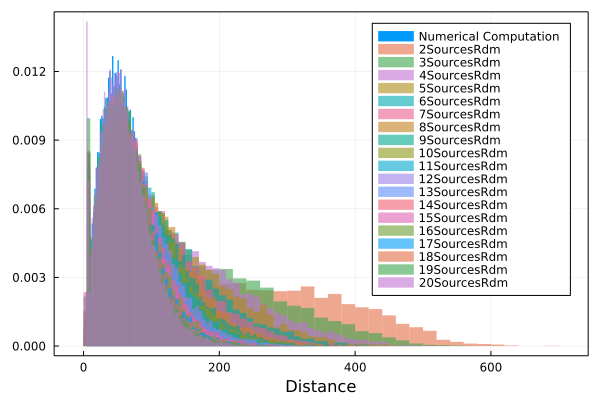

In [51]:
plot()
plot!(p, st=:histogram, normalized=true, linewidth=0, label="Numerical Computation")
for key in DS[1:19]
    plot!(d[key], st=:histogram, fillalpha=0.6, normalized=true, linewidth=0, label=key)
end
plot!(xlabel="Distance", frame=:box)

In [22]:
# plot(DS, [size(d[key],1) for key in DS], xrot=45, margin=20mm, legend=false, yscale=:log10)
# plot!(DS, [key*4000 for key in 2:20], xrot=45, margin=20mm, legend=false, yscale=:log10)

In [115]:
testCSV = CSV.read(PATH * "2SourcesRdm/test.csv", DataFrame)

512×512 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

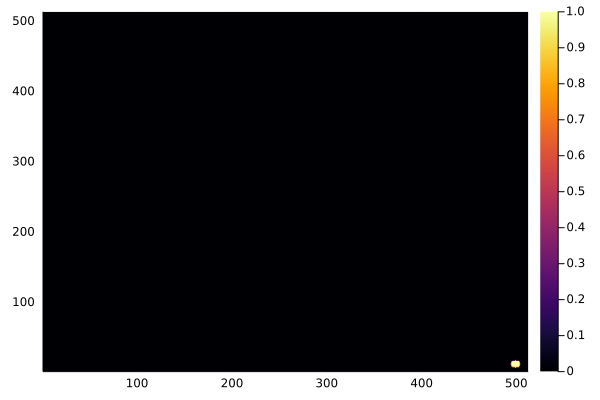

In [117]:
input = reshape(readdlm(PATH * "2SourcesRdm/test/" * testCSV[2239,1]),512,512)
heatmap(input)